In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

In [30]:
data = pd.read_excel("842 Risk Measurement Hallerbach - data for group assignment.xlsx", skiprows=9,index_col=0)
data

,Mkt,Tsies,CorpIG,CorpHY,AR,Oil
date,,,,,,
1994-12-30,1.000000,1.000000,1.000000,1.000000,1.000000,17.77
1995-01-03,0.997600,0.997267,0.997864,1.000572,1.008810,17.45
1995-01-04,1.001092,1.001366,1.001542,1.002199,1.015014,17.56
1995-01-05,1.000791,0.997262,0.999229,1.004223,1.014720,17.76
1995-01-06,1.002793,0.997943,1.000934,1.002199,1.013431,17.69
...,...,...,...,...,...,...
2024-12-05,23.208526,1.267491,5.042699,7.627386,8.021374,68.58
2024-12-06,23.293702,1.269549,5.050678,7.636052,7.859903,68.58
2024-12-09,23.125288,1.264409,5.039436,7.636756,7.906906,68.65


# Data Analyze

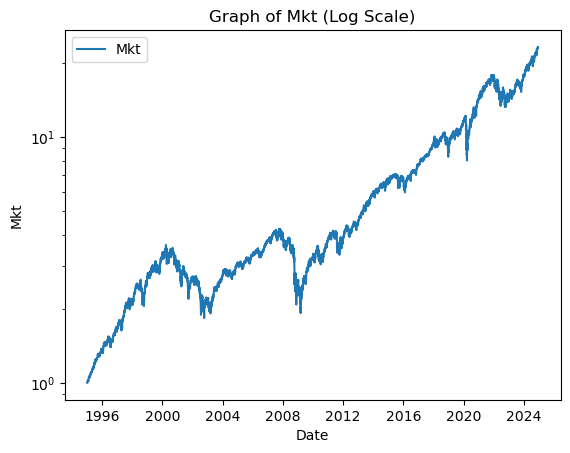

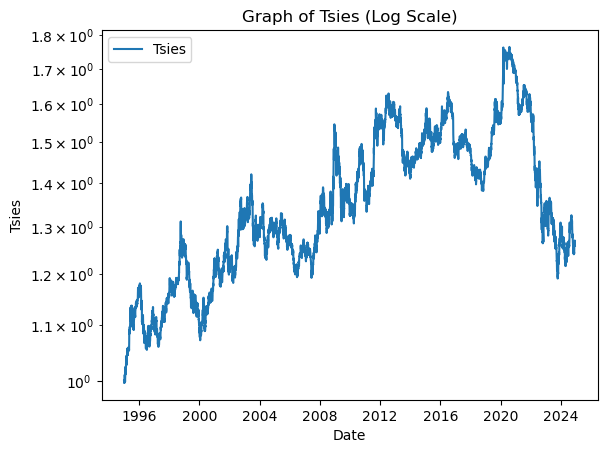

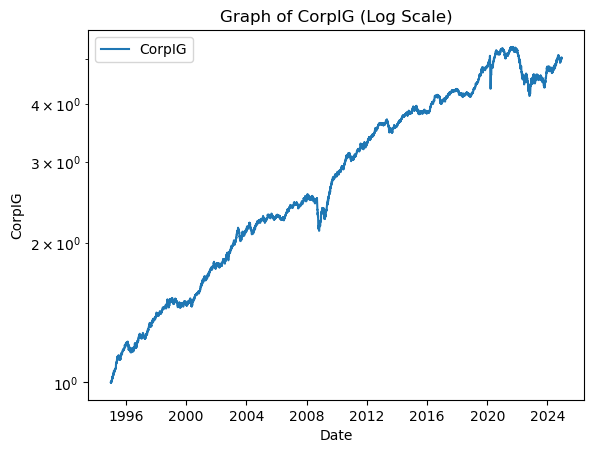

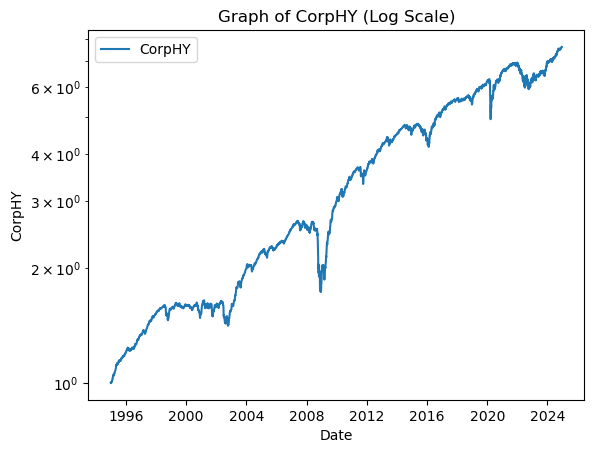

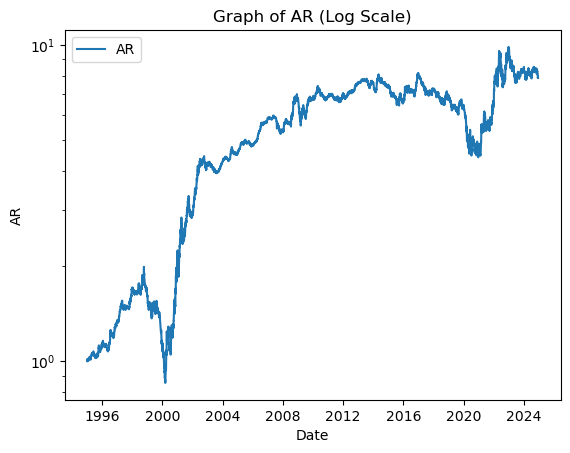

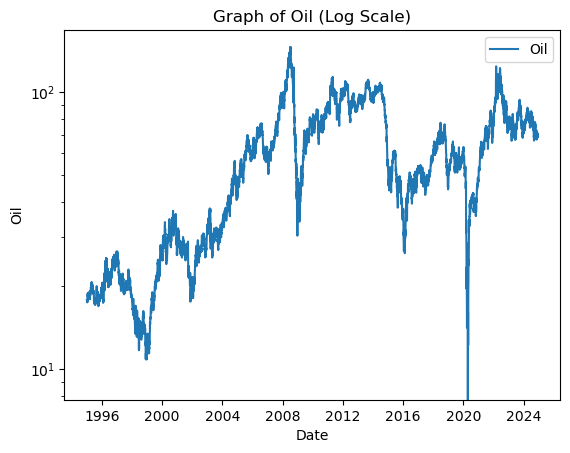

In [31]:
for column in data.columns:
    plt.figure()
    plt.plot(data.index, data[column], label=column)
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.title(f"Graph of {column} (Log Scale)")
    plt.xlabel("Date")
    plt.ylabel(column)
    plt.legend()
    plt.show()

Oil Case

In [32]:
data['Oil'] = data['Oil'].mask(data['Oil'] < 0).ffill()

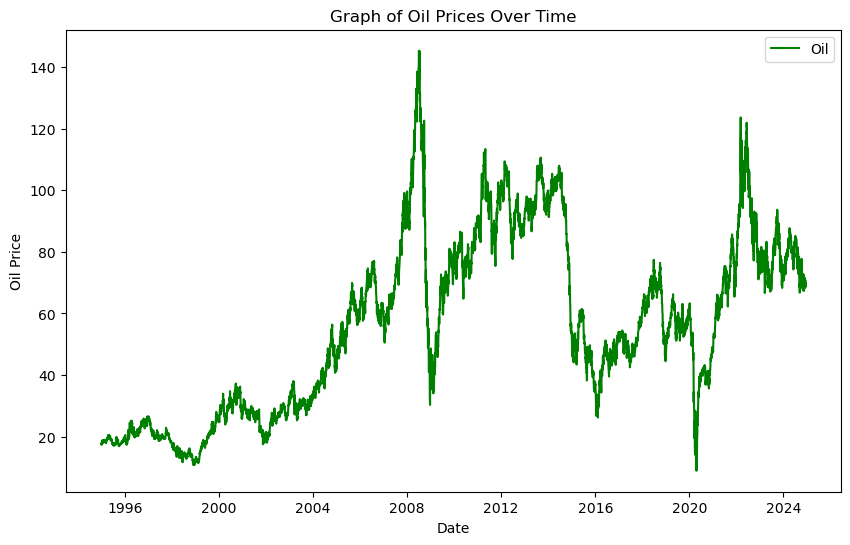

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Oil'], label='Oil', color='green')
plt.title("Graph of Oil Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Oil Price")
plt.legend()
plt.show()

In [34]:
data.describe().drop(['mean', 'std'])

,Mkt,Tsies,CorpIG,CorpHY,AR,Oil
count,7540.000000,7540.000000,7540.000000,7540.000000,7540.000000,7540.000
min,0.997600,0.996580,0.997864,1.000000,0.852990,8.910
25%,2.734407,1.231522,1.827808,1.612101,3.967228,29.220
50%,3.746252,1.330896,2.809636,2.990741,5.870791,54.985
75%,8.350029,1.491708,4.171117,5.395003,7.084868,78.320
max,23.293702,1.764456,5.320129,7.636756,9.859741,145.310


# Default and Augmented Portfolio

In [35]:
default_weights = ['0.5', '0.3', '0.05', '0', '0.1', '0.05']
augmented_weights = ['0.4', '0.4', '0', '0.05', '0.15', '0']

In [36]:
# Convert weights to numeric arrays
default_weights = np.array(default_weights, dtype=float)
augmented_weights = np.array(augmented_weights, dtype=float)

# Create an empty DataFrame
df_portfolio = pd.DataFrame()

# Calcul des rendements pour le portefeuille par défaut
df_portfolio['Default Portfolio'] = (data * default_weights).sum(axis=1)

# Calcul des rendements pour le portefeuille augmenté
df_portfolio['Augmented Portfolio'] = (data * augmented_weights).sum(axis=1)

In [37]:
df_portfolio['Default Portfolio Log Return'] = np.log(df_portfolio['Augmented Portfolio']) - np.log(df_portfolio['Augmented Portfolio'].shift(1))
df_portfolio['Augmented Portfolio Log Return'] = np.log(df_portfolio['Augmented Portfolio']) - np.log(df_portfolio['Augmented Portfolio'].shift(1))

df_portfolio.dropna(inplace=True)

df_portfolio.head()

,Default Portfolio,Augmented Portfolio,Default Portfolio Log Return,Augmented Portfolio Log Return
date,,,,
1995-01-03,1.821254,0.999297,-0.000703,-0.000703
1995-01-04,1.830534,1.003345,0.004043,0.004043
1995-01-05,1.839008,1.001640,-0.001701,-0.001701
1995-01-06,1.836669,1.002419,0.000777,0.000777
1995-01-09,1.821818,1.001747,-0.000671,-0.000671


In [41]:
rolling_vol_augmented = rolling_volatility(df_portfolio['Augmented Portfolio Log Return'], window)

In [39]:

rolling_vol_augmented2 = df_portfolio['Augmented Portfolio Log Return'].rolling(window).std() * np.sqrt(252)

GARCH 1 1

In [ ]:
def rolling_volatility(returns, window=20):
    vol = returns.rolling(window).std() * np.sqrt(252)
    return pd.DataFrame(vol, index=returns.index)

arch_mDP = arch_model(df_portfolio['Augmented Portfolio Log Return'] * 100, mean = 'Zero', vol = 'GARCH')
arch_mDP = arch_mDP.fit()

# Extracting confidence intervals
conf_int_DP = pd.DataFrame(arch_mDP.conf_int(alpha = .2))

# Creating the test
conf_int_DP['garchOneOne'] = arch_mDP.params

window = 100  # Taille de la fenêtre glissante
rolling_results = []

# Parcourir les données avec une fenêtre glissante
for start in range(len(df_portfolio['Augmented Portfolio Log Return']) - window):
    end = start + window
    rolling_data = df_portfolio['Augmented Portfolio Log Return'].iloc[start:end] * 100  # Multiplier par 100 pour le modèle GARCH
    
    # Ajuster le modèle GARCH sur la fenêtre actuelle
    rolling_model = arch_model(rolling_data, mean='Zero', vol='GARCH')
    fitted_model = rolling_model.fit(disp="off")
    
    # Extraire la volatilité conditionnelle pour la dernière observation de la fenêtre
    conditional_vol = fitted_model.conditional_volatility[-1]
    rolling_results.append(conditional_vol)

# Ajouter les résultats au DataFrame
# Ensure the length of rolling_results matches the length of the data index
rolling_results = [None] * (len(df_portfolio['Augmented Portfolio Log Return']) - len(rolling_results)) + rolling_results
df_portfolio['Rolling Conditional Volatility '] = rolling_results

plt.figure(figsize=(12, 6))

# Tracer la volatilité conditionnelle roulante
plt.plot(df_portfolio.index, df_portfolio['Rolling Conditional Volatility '], label='Rolling Conditional Volatility (GARCH)', color='blue', linestyle='dashed')

# Compute rolling volatility for the augmented portfolio
rolling_vol_augmented = rolling_volatility(df_portfolio['Augmented Portfolio Log Return'], window)

# Tracer la volatilité de l'Augmented Portfolio
plt.plot(rolling_vol_augmented.index, rolling_vol_augmented['Augmented Portfolio Log Return'], label='Rolling Volatility (Augmented Portfolio)', color='orange')

# Ajouter des titres et des légendes
plt.title("Rolling Conditional Volatility vs Augmented Portfolio Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 5297145.807890507
Iteration:      2,   Func. Count:     11,   Neg. LLF: 9688.845445643774
Iteration:      3,   Func. Count:     17,   Neg. LLF: 5785.15285214745
Iteration:      4,   Func. Count:     22,   Neg. LLF: 18686.15471783852
Iteration:      5,   Func. Count:     27,   Neg. LLF: 5701.230269577392
Iteration:      6,   Func. Count:     32,   Neg. LLF: 5703.3594807739555
Iteration:      7,   Func. Count:     37,   Neg. LLF: 5689.6019873048135
Iteration:      8,   Func. Count:     41,   Neg. LLF: 5689.587228674596
Iteration:      9,   Func. Count:     45,   Neg. LLF: 5689.587088892491
Iteration:     10,   Func. Count:     49,   Neg. LLF: 5689.5870874527245
Iteration:     11,   Func. Count:     52,   Neg. LLF: 5689.587087452907
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5689.5870874527245
            Iterations: 11
            Function evaluations: 52
            Gradient evaluations:

/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07177. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/var/folders/qk/340w2xz14r9768bjtzw6m6sc0000gn/T/ipykernel_20841/363882701.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conditional_vol = fitted_model.conditional_volatility[-1]
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
esti